# Word embeddings. Clustering the Yandex queries.
Data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1w_8MMe6uIwTejIVOEp8o60oc71USmCLw'}) 
downloaded.GetContentFile('logs')  

In [ ]:
import pandas as pd
data = pd.DataFrame([i[:-1].split('\t') for i in open('logs').readlines()[1:30000]], columns = ['text', 'data'])

In [ ]:
import re
def clear(x):
  return ' '.join(re.findall('[а-яА-ЯёЁ]+', x))
data['cl_text'] = data.text.apply(clear)
data['words'] = data.cl_text.apply(lambda x:x.split(' '))
data['len_words'] = data.words.apply(lambda x:len(x))
data.tail(15)

,text,data,cl_text,words,len_words
29984,лампа светодиодная коммутаторная лампа скл вни...,2018-06-20 08:17:06,лампа светодиодная коммутаторная лампа скл вни...,"[лампа, светодиодная, коммутаторная, лампа, ск...",9
29985,fdbnj,2018-06-20 08:17:06,,[],1
29986,общее домовое имущество в многоквартирном доме...,2018-06-20 08:17:06,общее домовое имущество в многоквартирном доме...,"[общее, домовое, имущество, в, многоквартирном...",8
29987,замена подшипника ремня генератора орел астра h,2018-06-20 08:17:06,замена подшипника ремня генератора орел астра,"[замена, подшипника, ремня, генератора, орел, ...",6
29988,emmet как добавить description,2018-06-20 08:17:06,как добавить,"[как, добавить]",2
29989,ваз 2104 бу челябинская область,2018-06-20 08:17:07,ваз бу челябинская область,"[ваз, бу, челябинская, область]",4
29990,beboo,2018-06-20 08:17:06,,[],1
29991,раковины с продолжением столешни,2018-06-20 08:17:07,раковины с продолжением столешни,"[раковины, с, продолжением, столешни]",4
29992,библиотеки кинеля вк,2018-06-20 08:17:07,библиотеки кинеля вк,"[библиотеки, кинеля, вк]",3
29993,белорусский вокзал,2018-06-20 08:17:07,белорусский вокзал,"[белорусский, вокзал]",2


Filter queries, which consist of 3 or more words

In [ ]:
longue_text = data[data.len_words>2]
longue_text.head()

,text,data,cl_text,words,len_words
4,вертикальном цилиндрическом сосуде над поршнем...,2018-06-17 09:30:32,вертикальном цилиндрическом сосуде над поршнем...,"[вертикальном, цилиндрическом, сосуде, над, по...",8
5,панель управления стиральной машины самсунг эк...,2018-06-17 09:30:32,панель управления стиральной машины самсунг эк...,"[панель, управления, стиральной, машины, самсу...",7
6,полки авито екатеринбург,2018-06-17 09:30:32,полки авито екатеринбург,"[полки, авито, екатеринбург]",3
7,зарплата санитарки в больнице боткина,2018-06-17 09:30:32,зарплата санитарки в больнице боткина,"[зарплата, санитарки, в, больнице, боткина]",5
8,аптека в кубинке торговля травами,2018-06-17 09:30:32,аптека в кубинке торговля травами,"[аптека, в, кубинке, торговля, травами]",5


In [ ]:
res = [i for j in longue_text.words.tolist() for i in j]
print(len(res), len(set(res)))
st_words = [i for i in set(res) if len(i)<4]

90077 25247


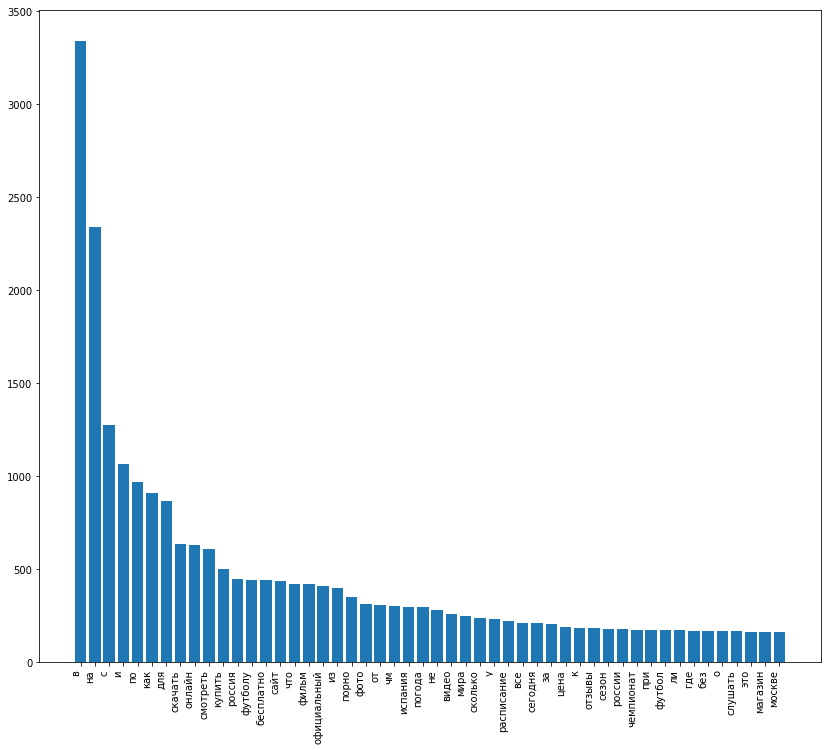

In [ ]:
from collections import Counter
plt.figure(figsize=(14, 12))

to_hist = [i for j,i in Counter(res).most_common(50)]
w_n = [j for j,i in Counter(res).most_common(50)]
plt.bar(range(len(to_hist)),to_hist, tick_label = w_n) 
plt.xticks(rotation=90, ha='right')
plt.show()

# Count Vectorizer

In [ ]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words=st_words, ngram_range=(1, 1), analyzer='word', max_df=.98, min_df=1)
X = vectorizer.fit_transform(longue_text.cl_text)
print(vectorizer.get_feature_names()[1100:1150])

['балнитце', 'баловались', 'балок', 'балохоновское', 'балткран', 'балуева', 'балчуг', 'балшие', 'балшои', 'балшой', 'баль', 'бальбоа', 'бальзам', 'бальнеотерапия', 'бальники', 'бальным', 'бамбини', 'бамбино', 'бамбука', 'бампер', 'банана', 'бананов', 'банд', 'бандаж', 'бандера', 'бандере', 'банды', 'бане', 'банеоцин', 'банеоцином', 'бани', 'банк', 'банка', 'банкам', 'банках', 'банке', 'банкет', 'банкетка', 'банки', 'банкиру', 'банкнота', 'банкноты', 'банков', 'банковский', 'банковское', 'банковской', 'банковскую', 'банкомат', 'банкоматах', 'банкомате']


In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [ ]:
CV(n_docs, n_words) -> UMAP(n_doc, n_feat) -> scatter
CV(n_docs, n_words) -> DBscan(n_docs, n_words) + labels(n_docs, 1)

SyntaxError: ignored

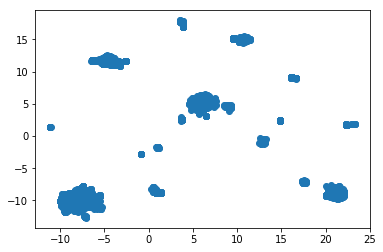

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1])

## DBscan

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/400px-DBSCAN-Illustration.svg.png)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/DBSCAN-density-data.svg/800px-DBSCAN-density-data.svg.png)



In [ ]:
db = DBSCAN(eps=0.005, min_samples=10).fit(X)

In [ ]:
print(len(set(db.labels_))) # number  of different classes 

23


In [ ]:
longue_text['CV_labels'] =  db.labels_
without_dupl = longue_text[['cl_text', 'CV_labels']].drop_duplicates()
gr = without_dupl.groupby('CV_labels')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for i, j  in list(gr.groups.items())[:10:-1]:
  print(i,gr.get_group(i))

21                                              cl_text  CV_labels
9802  смотреть фильмы года новинки которые уже вышли         21
20                cl_text  CV_labels
8523  дом свежие серии         20
19               cl_text  CV_labels
5416  майл почта вход         19
18                          cl_text  CV_labels
4868         матч россия испания         18
22204  россия испания на матч тв         18
17                     cl_text  CV_labels
4483       россия и испания         17
4615      россия испания чм         17
25651    гол россия испания         17
25866    испания россия гол         17
26440  гол испания и россия         17
16                     cl_text  CV_labels
4168  футбол россия испания         16
4707  россия испания футбол         16
15                              cl_text  CV_labels
4084      россия испания прямой эфир         15
4202      прямой эфир россия испания         15
5250      испания россия прямой эфир         15
26047  россия испания чм прямой эфир      

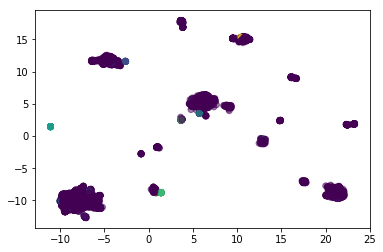

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c = db.labels_, alpha=0.5)

In [ ]:
len(gr.get_group(-1))/ len(longue_text.cl_text)*100

93.41186736474695

# CV + SVD

In [ ]:
CV - SVD - UMAP - SCATTER

In [ ]:
print(X.shape)
svd = TruncatedSVD(n_components=300, algorithm='randomized', n_iter=5)
X_svd = svd.fit_transform(X)
print(X_svd.shape)

(18336, 24016)
(18336, 300)


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 23 separate connected components using meta-embedding (experimental)
  n_components


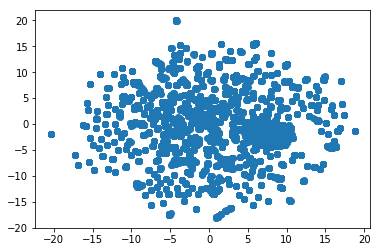

In [ ]:
reducer = umap.UMAP()
embedding_svd = reducer.fit_transform(X_svd)
plt.scatter(embedding_svd[:, 0], embedding_svd[:, 1])

In [ ]:
db = DBSCAN(eps=0.005, min_samples=10).fit(X_svd)
labels_svd = db.labels_

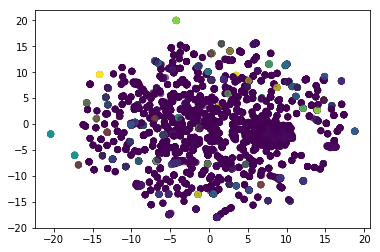

In [ ]:
plt.scatter(embedding_svd[:, 0], embedding_svd[:, 1], c = labels_svd, alpha=0.5)

In [ ]:
len(set(labels_svd))

101

# Tf-idf

In [ ]:
print(longue_text.shape)
longue_text.drop_duplicates(subset ="cl_text", keep = False, inplace = True) 
print(longue_text.shape)

(18336, 6)
(16732, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
not_clustered = longue_text[longue_text['CV_labels']==-1]
print(not_clustered.shape)
not_clustered.head()

(16686, 6)


,text,data,cl_text,words,len_words,CV_labels
4,вертикальном цилиндрическом сосуде над поршнем...,2018-06-17 09:30:32,вертикальном цилиндрическом сосуде над поршнем...,"[вертикальном, цилиндрическом, сосуде, над, по...",8,-1
5,панель управления стиральной машины самсунг эк...,2018-06-17 09:30:32,панель управления стиральной машины самсунг эк...,"[панель, управления, стиральной, машины, самсу...",7,-1
6,полки авито екатеринбург,2018-06-17 09:30:32,полки авито екатеринбург,"[полки, авито, екатеринбург]",3,-1
7,зарплата санитарки в больнице боткина,2018-06-17 09:30:32,зарплата санитарки в больнице боткина,"[зарплата, санитарки, в, больнице, боткина]",5,-1
8,аптека в кубинке торговля травами,2018-06-17 09:30:32,аптека в кубинке торговля травами,"[аптека, в, кубинке, торговля, травами]",5,-1


## kMeans
![alt text](https://shapeofdata.files.wordpress.com/2013/07/kmeans.png)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
TF_idf_vec = TfidfVectorizer()
X_tfidf = TF_idf_vec.fit_transform(not_clustered.cl_text)
db = KMeans(n_clusters = 20).fit(X_tfidf)
labels_tf = db.labels_
reducer = umap.UMAP()
embedding_tf = reducer.fit_transform(X_tfidf)

In [ ]:
TFIDF - UMAP -          SCATTER
      - KMEANS (LABELS)-

NameError: ignored

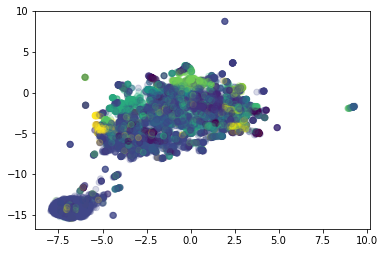

In [ ]:
plt.scatter(embedding_tf[:, 0], embedding_tf[:, 1], c = labels_tf, alpha=0.2)

In [ ]:
print(len(set(db.labels_)))
not_clustered['tfidf_labels'] = db.labels_
gr_tf = not_clustered[['cl_text','tfidf_labels']].groupby('tfidf_labels')
for i, j  in list(gr_tf.groups.items())[:5]:
  print(i,gr_tf.get_group(i))

20
0                                                  cl_text  tfidf_labels
33                                  средство от геморроя             0
102                                  гарри и меган фильм             0
149        темрюк достопримечательности фото с описанием             0
204    салат из брокколи рецепты с фото простые и вку...             0
239                        мир дикого запада сезон серия             0
244                             послеродовой бандаж фото             0
301                  кипр протарас лучшие экскурсии цена             0
382                            пвх трубы цена за метр мм             0
448    фото и цена диванов в магазине громада белово ...             0
509       фильм вертикаль с участием владимира высоцкого             0
554                                идеальный голос фильм             0
660                         фоторамки с движущимися фото             0
691         от киселовска до чумиша сколько стоить такси             0
7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Tf-idf + svd

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


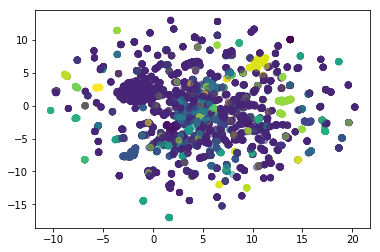

In [ ]:
TF_idf_vec = TfidfVectorizer()
X_tfidf = TF_idf_vec.fit_transform(not_clustered.cl_text)
svd = TruncatedSVD(n_components=300, algorithm='randomized', n_iter=5)
X_tfidf_svd = svd.fit_transform(X_tfidf)
db = KMeans(n_clusters=20).fit(X_tfidf_svd)
labels_tf_svd = db.labels_
reducer = umap.UMAP()
embedding_tf_svd = reducer.fit_transform(X_tfidf_svd)
plt.scatter(embedding_tf_svd[:, 0], embedding_tf_svd[:, 1], c = labels_tf_svd, alpha=0.5)

In [ ]:
print(len(set(db.labels_)))
not_clustered['tfidf_svd_labels'] = db.labels_
gr_tf_svd = not_clustered[['cl_text','tfidf_svd_labels']].groupby('tfidf_svd_labels')
for i, j  in list(gr_tf_svd.groups.items())[:5]:
  print(i,gr_tf_svd.get_group(i))

20
0                                                  cl_text  tfidf_svd_labels
1678   поделки из дерева на участках в детском саду л...                 0
1868   электрический тёплый пол на деревянный пол сво...                 0
1997         как сделать ромашки из бумаги своими руками                 0
4169   как установить москитные сетки на пластиковые ...                 0
5542   убийца карасям из одной кормушки своими руками...                 0
5592                подарок своими руками на день медика                 0
5859                   циклон для пылесоса своими руками                 0
5947                      уложить линолеум своими руками                 0
6321                       как крутить самокрутки руками                 0
6466   поздравить лучшую подругу с свадьбой своими сл...                 0
7381                светильники из изолона своими руками                 0
7759   пневматическая пушка с компрессором своими руками                 0
7930   как сделать ч

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Word2vec

In [ ]:
import torch
import numpy as np

vocab = 1000

embed = torch.nn.Linear(vocab, 300)
lin = torch.nn.Linear(300, vocab)

one_hot = np.zeros((vocab,vocab), float)
np.fill_diagonal(one_hot, 1)

res = lin(embed(torch.torch.from_numpy(one_hot).float()))
res.shape

torch.Size([1000, 1000])

In [ ]:
res.detach().numpy()==one_hot

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Pretrained word2vec with skip-gram

In [ ]:
!wget http://vectors.nlpl.eu/repository/11/182.zip

--2019-10-12 09:57:12--  http://vectors.nlpl.eu/repository/11/182.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637613765 (608M) [application/zip]
Saving to: ‘182.zip’

182.zip             100%[===================>] 608.08M  23.0MB/s    in 38s     

2019-10-12 09:57:51 (16.1 MB/s) - ‘182.zip’ saved [637613765/637613765]



In [ ]:
from zipfile import ZipFile
with ZipFile('182.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
!pip install gensim==3.7.0

In [ ]:
!pip install gensim
import gensim
from gensim import interfaces, utils, matutils
from gensim.matutils import dirichlet_expectation, mean_absolute_difference

In [ ]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format('model.bin', binary=True) 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
list(wv.vocab.keys())[:10]

['xxxxxxxx_NUM',
 'год_NOUN',
 'xxxxxx_NUM',
 'xxxxxxx_NUM',
 'человек_NOUN',
 'время_NOUN',
 'первый_ADJ',
 'один_NUM',
 'так_ADV',
 'мочь_VERB']

In [ ]:
len(wv.vocab.keys())

248978

In [ ]:
trans_vocab = {word.split('_')[0]: word for word in list(wv.vocab.keys())}

In [ ]:
len(trans_vocab.keys())

207788

In [ ]:
def to_vec(x):
  words = x.split(' ')
  res_vec = np.zeros(300)
  for i in words:
    try:
      res_vec+=wv[trans_vocab[i]]
    except KeyError:
      continue
  return res_vec    
not_clustered['v2v_skip_gr'] = not_clustered.cl_text.apply(to_vec) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
W2V - SUM - KMEANS(LABELS) - SCATTER
          - UMAP - 

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


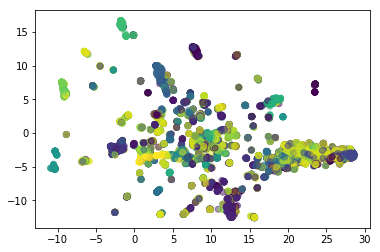

In [ ]:
db = KMeans(n_clusters=20).fit(not_clustered.v2v_skip_gr.tolist())
labels_v2v_skip_gr = db.labels_
reducer = umap.UMAP()
embedding_v2v_skip_gr = reducer.fit_transform(not_clustered.v2v_skip_gr.tolist())
plt.scatter(embedding_v2v_skip_gr[:, 0], embedding_v2v_skip_gr[:, 1], c = labels_v2v_skip_gr, alpha=0.5)

In [ ]:
not_clustered['v2v_skip_gr_labels'] = db.labels_
gr_v2v_skip_gr = not_clustered[['cl_text','v2v_skip_gr_labels']].groupby('v2v_skip_gr_labels')
for i, j  in list(gr_v2v_skip_gr.groups.items())[:5]:
  print(i,gr_v2v_skip_gr.get_group(i))

0                                                  cl_text  v2v_skip_gr_labels
22                       микрофон для магнитолы в машину                   0
33                                  средство от геморроя                   0
38                           шампунь для гладкости волос                   0
39                                после орви температура                   0
43     лучшее диагностическое оборудование для автомо...                   0
58                              вакуумный очиститель пор                   0
90                        печенье через мясорубку рецепт                   0
117                        переходник на для канализации                   0
151      красивые чехлы для телефонов рязань дешево цены                   0
197              панели пвх для ванной в сарае ульяновск                   0
241                    панангин инструкция по применению                   0
244                             послеродовой бандаж фото                  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


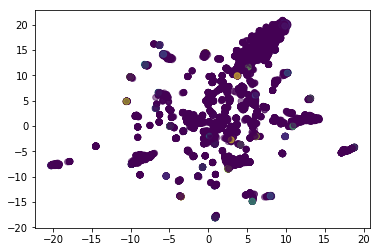

In [ ]:
db = DBSCAN(eps=0.00005, min_samples=10).fit(not_clustered.v2v_skip_gr.tolist())
labels_v2v_skip_gr = db.labels_
reducer = umap.UMAP()
embedding_v2v_skip_gr = reducer.fit_transform(not_clustered.v2v_skip_gr.tolist())
plt.scatter(embedding_v2v_skip_gr[:, 0], embedding_v2v_skip_gr[:, 1], c = labels_v2v_skip_gr, alpha=0.5)

In [ ]:
gr_v2v_skip_gr = not_clustered[['cl_text','v2v_skip_gr_labels']].groupby('v2v_skip_gr_labels')
for i, j in list(gr_v2v_skip_gr.groups.items())[:5]:
  print(i,gr_v2v_skip_gr.get_group(i))

0                                                  cl_text  v2v_skip_gr_labels
22                       микрофон для магнитолы в машину                   0
33                                  средство от геморроя                   0
38                           шампунь для гладкости волос                   0
39                                после орви температура                   0
43     лучшее диагностическое оборудование для автомо...                   0
58                              вакуумный очиститель пор                   0
90                        печенье через мясорубку рецепт                   0
117                        переходник на для канализации                   0
151      красивые чехлы для телефонов рязань дешево цены                   0
197              панели пвх для ванной в сарае ульяновск                   0
241                    панангин инструкция по применению                   0
244                             послеродовой бандаж фото                  

# Elmo

In [ ]:
vec(я) - vec(туда) 
vec(иду) - vec(домой)



[softmax[vec(я)*vec(туда) , vec(я)*vec(домой)],
 softmax[vec(иду)*vec(туда), vec(иду)*vec(домой)]]

 [[0.4, 0,6],
 [0.3, 0.7]]

 [[1,0]
  [0,1]]


In [ ]:
!wget http://vectors.nlpl.eu/repository/11/170.zip

--2019-10-18 12:20:05--  http://vectors.nlpl.eu/repository/11/170.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474536163 (453M) [application/zip]
Saving to: ‘170.zip’

170.zip             100%[===================>] 452.55M  21.8MB/s    in 25s     

2019-10-18 12:20:36 (17.8 MB/s) - ‘170.zip’ saved [474536163/474536163]



In [ ]:
!mkdir rus_model
!cp 170.zip rus_model
!ls rus_model

170.zip


In [ ]:
from zipfile import ZipFile
with ZipFile('rus_model/170.zip', 'r') as zipObj:
  zipObj.extractall('./rus_model')

In [ ]:
!rm rus_model/170.zip

In [ ]:
!ls rus_model

char.dic     encoder.pkl  README	      word.dic
config.json  meta.json	  token_embedder.pkl


In [ ]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs

Cloning into 'ELMoForManyLangs'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 174 (delta 0), reused 2 (delta 0), pack-reused 171
Receiving objects: 100% (174/174), 86.67 KiB | 1.55 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
#!python ELMoForManyLangs//setup.py install

In [ ]:
!head rus_model/config.json

{"seed": 1, "gpu": 2, "train_path": "/users4/conll18st/raw_text/Russian/ru-20m.raw", "valid_path": null, "test_path": null, "config_path": "/users4/conll18st/elmo/configs/cnn_50_100_512_4096_sample.json", "word_embedding": null, "optimizer": "adam", "lr": 0.001, "lr_decay": 0.8, "model": "/users4/conll18st/elmo/src/final_models/ru.model", "batch_size": 32, "max_epoch": 10, "clip_grad": 5, "max_sent_len": 20, "min_count": 3, "max_vocab_size": 150000, "save_classify_layer": false, "valid_size": 0, "eval_steps": 10000}


In [ ]:
!pip install -e ELMoForManyLangs/

Obtaining file:///content/ELMoForManyLangs
  Created wheel for overrides: filename=overrides-2.0-cp36-none-any.whl size=4222 sha256=f4ac2fdb394f8859887e93f1bb5b130317bde67f6ed95ddcae5bf1ec6de099cc
  Stored in directory: /root/.cache/pip/wheels/67/ab/57/d68b6dad468ff96b792770a83229451add2b347b0c12a10300
Successfully built overrides
  Running setup.py develop for elmoformanylangs


In [ ]:
!ls ELMoForManyLangs/configs

cnn_0_100_512_4096_sample.json	cnn_50_100_512_4096_sample.json


In [ ]:
import json
with open('rus_model/config.json') as json_file:
    data = json.load(json_file)

In [ ]:
data['config_path'] = '../ELMoForManyLangs/configs/cnn_50_100_512_4096_sample.json'

In [ ]:
with open('rus_model/config.json', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
from ELMoForManyLangs.elmoformanylangs import Embedder
e = Embedder('./rus_model/')

2019-10-18 12:22:16,188 INFO: char embedding size: 3896
2019-10-18 12:22:17,745 INFO: word embedding size: 329681
2019-10-18 12:22:20,264 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(329681, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(3896, 50, padding_idx=3893)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

In [ ]:
not_clustered.head()

In [ ]:
words_fwc = not_clustered.words.tolist()
res = e.sents2elmo(words_fwc)

2019-09-12 11:18:36,145 INFO: 219 batches, avg len: 7.0
2019-09-12 11:18:38,286 INFO: Finished 1000 sentences.
2019-09-12 11:18:40,394 INFO: Finished 2000 sentences.
2019-09-12 11:18:42,376 INFO: Finished 3000 sentences.
2019-09-12 11:18:46,927 INFO: Finished 4000 sentences.
2019-09-12 11:18:48,929 INFO: Finished 5000 sentences.
2019-09-12 11:18:50,975 INFO: Finished 6000 sentences.
2019-09-12 11:18:52,861 INFO: Finished 7000 sentences.
2019-09-12 11:18:54,835 INFO: Finished 8000 sentences.
2019-09-12 11:18:56,814 INFO: Finished 9000 sentences.
2019-09-12 11:18:58,669 INFO: Finished 10000 sentences.
2019-09-12 11:19:00,612 INFO: Finished 11000 sentences.
2019-09-12 11:19:02,869 INFO: Finished 12000 sentences.
2019-09-12 11:19:04,986 INFO: Finished 13000 sentences.


In [ ]:
len(res), not_clustered.shape

(13967, (13967, 9))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


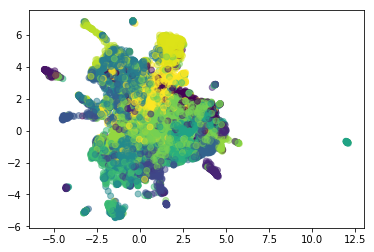

In [ ]:
not_clustered['elmo_'] = res
def sum_vec(x):
  return sum([i for i in x])
not_clustered['elmo'] =  not_clustered['elmo_'].apply(sum_vec)
db = KMeans(n_clusters=20).fit(not_clustered.elmo.tolist())
labels_elmo = db.labels_
reducer = umap.UMAP()
embedding_elmo = reducer.fit_transform(not_clustered.elmo.tolist())
plt.scatter(embedding_elmo[:, 0], embedding_elmo[:, 1], c = labels_elmo, alpha=0.5)

In [ ]:
not_clustered['elmo_lbls'] = db.labels_
gr_elmo = not_clustered[['cl_text','elmo_lbls']].groupby('elmo_lbls')
for i, j  in list(gr_elmo.groups.items())[:5:-1]:
  print(i,gr_elmo.get_group(i))

19                                                  cl_text  elmo_lbls
7                  зарплата санитарки в больнице боткина         19
30                         как кошка зовет котят слушать         19
46                             ростовметео в пролетарске         19
61                                 слушать бьюти ин блек         19
63                                        моя игра баста         19
108            притча про мужчину который много работает         19
119                              фигурки динозавров раро         19
120         владимир стеклов биография личная жизнь дети         19
187                          дикая кошка на гербе пскова         19
196                                    волк с уолл стрит         19
222                       додо пицца домодедово курыжова         19
245                        лионель месси против исландии         19
253                              урочище джилы су погода         19
254                                        др

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Bert embeddings

In [ ]:
!pip install bert-embedding

In [ ]:
%%time
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding(model='bert_12_768_12', dataset_name='wiki_multilingual_cased')
sentences = not_clustered.cl_text.tolist()[:1000]
result = bert_embedding(sentences)

CPU times: user 2min 55s, sys: 3.25 s, total: 2min 58s
Wall time: 1min 42s


In [ ]:
result[1][0]

['[UNK]',
 'панель',
 'управления',
 'стиральной',
 'машины',
 'самсунг',
 'эко',
 'бабл',
 '[UNK]']

In [ ]:
not_clustered = not_clustered[:1000]
not_clustered.shape

(1000, 8)

In [ ]:
len([i[1] for i in result][0])

10

In [ ]:
from sklearn.cluster import KMeans

not_clustered['bert'] = [np.sum(i[1],axis=0) for i in result]
not_clustered['bert'][:1].values

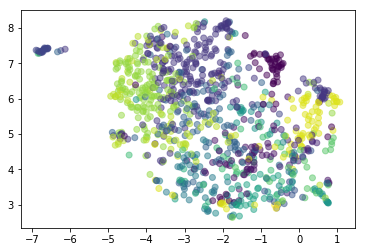

In [ ]:
db = KMeans(n_clusters=20).fit(not_clustered.bert.tolist())
labels_bert = db.labels_
reducer = umap.UMAP()
embedding_bert = reducer.fit_transform(not_clustered.bert.tolist())
plt.scatter(embedding_bert[:, 0], embedding_bert[:, 1], c = labels_bert, alpha=0.5)

In [ ]:
not_clustered['elmo_lbls'] = db.labels_
gr_elmo = not_clustered[['cl_text','elmo_lbls']].groupby('elmo_lbls')
for i, j  in list(gr_elmo.groups.items())[:5:-1]:
  print(i,gr_elmo.get_group(i))

19                                                 cl_text  elmo_lbls
251   если поражение головного мозга в результате тр...         19
1289  если поражение головного мозга в результате тр...         19
1596  выполнение какой из должностных обязанностей с...         19
18                                                 cl_text  elmo_lbls
7                 зарплата санитарки в больнице боткина         18
8                     аптека в кубинке торговля травами         18
19             праздники сегодня полный список в россии         18
23                                батутный центр в меге         18
74                      стесняюсь играть в ролевые игры         18
101                        офд ру вход в личный кабинет         18
104                работа в иркутске вакансии без опыта         18
159                    адидас дисконт в тамбове каталог         18
177            талисман любви сериал в хорошем качестве         18
187                         дикая кошка на гербе пскова 

# Около футбола 

In [ ]:
words_fwc = [ 'футбол', 'чемпионат','чм', 'матч', 'финал','полуфинал', '1 4', '1 2', '1 8']
words_fwatch = [ 'трансляция матча', 'трансляция чм', 'результаты чм', 'смотреть чм', 'смотреть россия','смотреть матч', 'смотреть чм', 'запись', 'эфир матч', 'эфир чм','трансляция финал','трансляция футбол', 'смотреть футбол', 'запись футбол', 'запись игра','смотреть чемпионат']
words_fschedule = ['турнирная таблица', 'турнирная сетка', 'расписание чм', 'календарь футбол', 'календарь чм', 'календарь чемпионат' 'футбол турнирная таблица','чм турнирная таблица', 'чм турнирная сетка', 'футбол турнирная сетка',]
words_finfo = [ 'статистика матчей','счет футбол', 'счет матча', 'ход матча','счет игра', 'счет россия', 'промежуточные результаты', 'результаты футбол',  ]
words_fplayers = [ 'статистика игроков', 'состав команд', 'статистика команд', 'игроки', 'футбольный тренер', 'cборная' ]
words_fnews = [ 'новости футбола', 'комментарии футбол', 'обзор матча', 'аналитика чм', 'аналитика матча', 'обзор чм']


In [ ]:
al = []
al.extend(words_fwc)
al.extend(words_fwatch)
al.extend(words_fschedule)
al.extend(words_finfo)
al.extend(words_fplayers)
al.extend(words_fnews)
labels = ['wc' for i in range(len(words_fwc))]+['watch' for i in range(len(words_fwatch))]+['schedule' for i in range(len(words_fschedule))]+['info' for i in range(len(words_finfo))]+['players' for i in range(len(words_fplayers))]+['news' for i in range(len(words_fnews))]
f_dict = list(zip(al, labels))
f_dict.sort(key=lambda t: len(t[0]), reverse=True)
f_dict[1:]

[('промежуточные результаты', 'info'),
 ('футбол турнирная сетка', 'schedule'),
 ('чм турнирная таблица', 'schedule'),
 ('смотреть чемпионат', 'watch'),
 ('чм турнирная сетка', 'schedule'),
 ('статистика игроков', 'players'),
 ('комментарии футбол', 'news'),
 ('трансляция футбол', 'watch'),
 ('турнирная таблица', 'schedule'),
 ('статистика матчей', 'info'),
 ('результаты футбол', 'info'),
 ('статистика команд', 'players'),
 ('футбольный тренер', 'players'),
 ('трансляция матча', 'watch'),
 ('трансляция финал', 'watch'),
 ('календарь футбол', 'schedule'),
 ('смотреть россия', 'watch'),
 ('смотреть футбол', 'watch'),
 ('турнирная сетка', 'schedule'),
 ('новости футбола', 'news'),
 ('аналитика матча', 'news'),
 ('трансляция чм', 'watch'),
 ('результаты чм', 'watch'),
 ('смотреть матч', 'watch'),
 ('запись футбол', 'watch'),
 ('расписание чм', 'schedule'),
 ('состав команд', 'players'),
 ('календарь чм', 'schedule'),
 ('аналитика чм', 'news'),
 ('смотреть чм', 'watch'),
 ('смотреть чм', 'w

In [ ]:
def filter(text):
  f = []
  for word, label in f_dict[1:]:
    if word in text:
      f.append(label)
  if len(f)!=0:
    return f[0]
  else:
    return 1
    
data['labels'] = data.text.apply(filter)


In [ ]:
f_data = data[data.labels!=1]
print(f_data.shape)
f_data.head()

(267119, 3)


,text,data,labels
84,чемпионат мира по футболу 2018,2018-06-17 09:23:58,wc
103,поделки к футболу,2018-06-17 09:23:59,wc
128,онлайн запись к в,2018-06-17 09:24:01,watch
145,чемпионат мира по футболу 2018,2018-06-17 09:24:02,wc
157,состав мексики по футболу 218,2018-06-17 09:24:03,wc


In [ ]:
f_data.tail()

,text,data,labels
9999821,матч аргентина хорватия чемпионат мира 2018 см...,2018-06-24 13:48:22,wc
9999864,расписание матчей чемпионата мира по футболу 2...,2018-06-15 11:18:43,wc
9999876,обзор чм по футболу 2018,2018-06-15 11:18:43,news
9999889,чемпионат логотип,2018-06-15 11:18:43,wc
9999967,жирков футболист википедия,2018-06-15 11:18:46,wc


In [ ]:
f_data = f_data.reset_index()
def d(x):
  s = x[:10].split('-')
  return s[1]+s[2]
f_data['d'] = f_data['data'].apply(d)
f_data.head()

,index,text,data,labels,d
0,84,чемпионат мира по футболу 2018,2018-06-17 09:23:58,wc,0617
1,103,поделки к футболу,2018-06-17 09:23:59,wc,0617
2,128,онлайн запись к в,2018-06-17 09:24:01,watch,0617
3,145,чемпионат мира по футболу 2018,2018-06-17 09:24:02,wc,0617
4,157,состав мексики по футболу 218,2018-06-17 09:24:03,wc,0617


In [ ]:
pr_data = f_data[['labels', 'text']].groupby(['labels'])
for i, val in pr_data:
  print(i)
  print(set(val.text.tolist()[:250]))
  print('###########')

info
{'какой счет россия выиграет', 'результаты футбольных матчей', 'счет матча россия испания футбол сейчас', 'результаты футбол ч м', 'какой будет счет россия хорватия', 'счет футбола франция бельгия', 'какой счет футбола сегодня россия испания', 'счет россия испания чемпионат мира', 'испания португалия счет матча', 'счет матча россия саудовская аравия', 'какой счет футбола сегодня россия египет', 'узнать счет футбольного матча за 16 06 2018', 'дель потро х м лопес ф счет матча результат матча', 'счет россия и испания', 'сообщить счет матча англия тунис', 'какой счет футбола сегодня уругвай и саудовской аравии', 'счет матча англия хорватия чм 2018 11 июля2018', 'россия египет счет матча 19 июня', 'счет матча франция хорватия', 'счет россия египет', 'счет футбол россия', 'счет футбольного матча португалия испания чемпионат мира 18 года в сочи', 'статистика матчей россия бразилия волейбол', 'какой счет россия испания футбол 2018', 'какой счет футбола сегодня франция и бельгия', 'какой 

In [ ]:
g_f_data = f_data[['d', 'labels']].groupby(['d', 'labels']).size().reset_index(name='counts')
kkk = g_f_data[g_f_data.counts>2]

In [ ]:
gh = kkk.pivot(index='labels', columns='d', values='counts')
gh.head()

d,0614,0615,0616,0617,0618,0619,0620,0621,0622,0623,...,0706,0707,0708,0709,0710,0711,0712,0713,0714,0715
labels,,,,,,,,,,,,,,,,,,,,,
info,144,44,24,40,16,140,96,19,18,25,...,39,135,247,14,18,29,19,5,17,45
news,46,51,46,32,19,31,71,26,21,26,...,28,26,51,11,20,15,31,13,25,20
players,22,43,22,20,15,24,26,15,14,16,...,28,12,18,14,17,13,14,9,16,19
schedule,228,343,372,506,360,430,924,561,738,670,...,490,364,322,99,161,207,190,101,144,193
watch,739,634,407,384,566,1313,748,423,392,287,...,483,1113,276,360,495,470,348,297,267,542


In [ ]:
gh = gh.fillna(0.1)
gh = gh.reset_index()

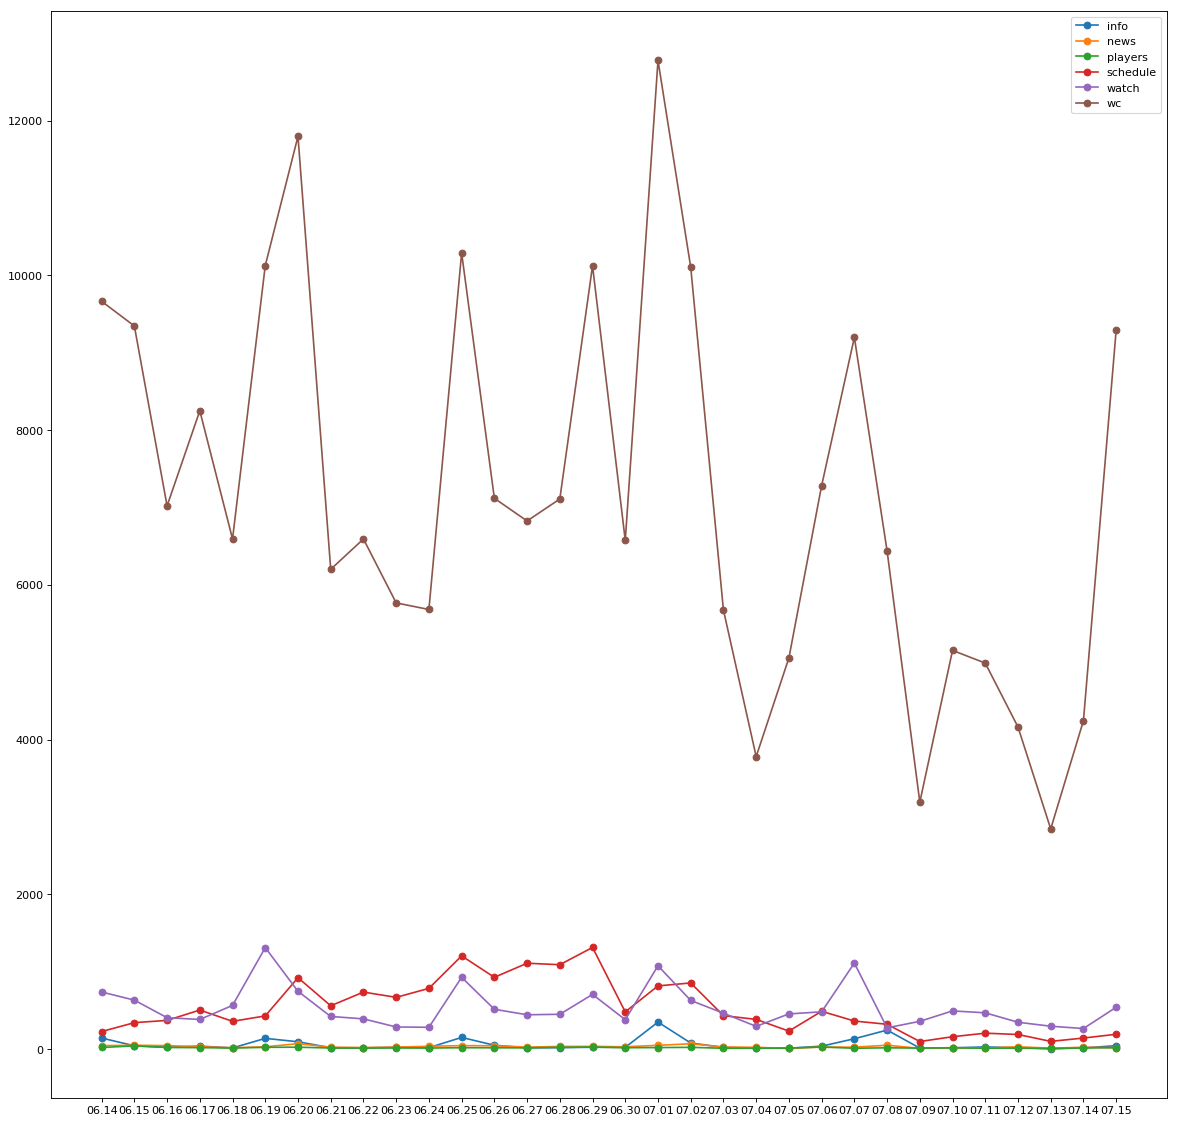

In [ ]:
x = [i for i in range(32)]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k')
for indx,i in enumerate(gh.values):
  plt.plot(x, i[1:], '-o', label = i[0])
plt.xticks(x, (str(i[:2])+'.'+str(i[2:]) for i in gh.columns[1:]))
plt.legend()
plt.show()

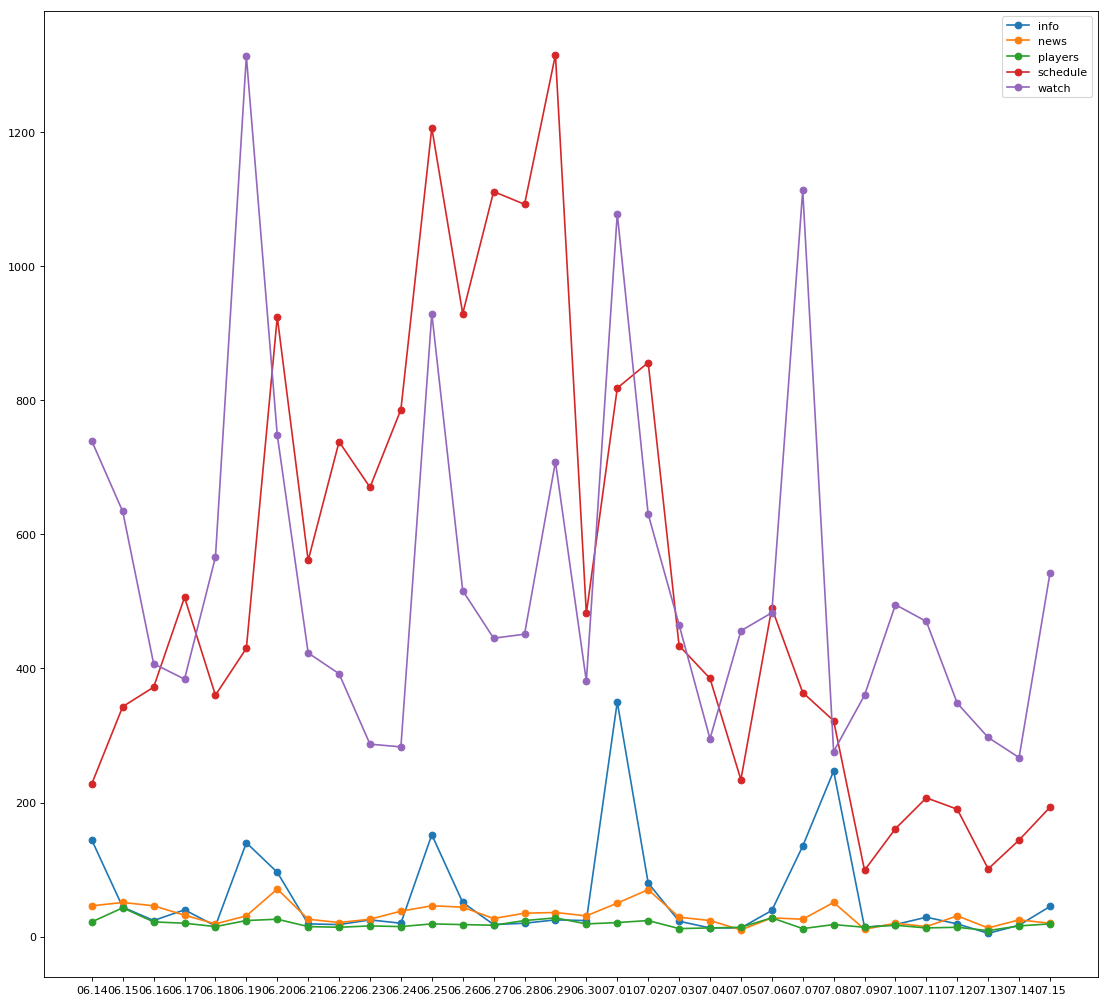

In [ ]:
x = [i for i in range(32)]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(17, 16), dpi=80, facecolor='w', edgecolor='k')
for indx,i in enumerate(gh.values[:-1]):
  plt.plot(x, i[1:], '-o', label = i[0])
plt.xticks(x, (str(i[:2])+'.'+str(i[2:]) for i in gh.columns[1:]))
plt.legend()
plt.show()